In [1]:
# default_exp smoothing

# Pset2

> Adjusting series, SA, MA, and exponential smoothing forecast.

In [2]:
#hide
from nbdev.showdoc import *

Questions:
    
1.  Adjust the GDP Series for population.  Be careful to match the units in order to obtain a meaningful number.

2.  Adjust the GDP for price changes.  Feel free to use any year after 2000 as "reference".  Use quarter 3 of that year GDP deflator.

3.  Seasonally adjust the series.

3. Obtain the closest Moving Average forecast.  You can use RMSE as a measure of performance.  You must evaluate at least two different MA "lengths" (i.e. 2-quarter MA and 3-quarter MA, etc.)

4. Obtain the closest exponential smoothing forecast.  Use at least two methods. 

5. Compare the best MA forecast with the best Exponential Smoothing forecast.
    

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from forecast import moving_avg as ma

## Load data

### NSA GDP and SA GDP

Billions of Dollars, Quarterly

In [4]:
df = pd.read_excel("../data/pset2/Quarterly_GDP.xls")
df.columns = ['DATE', 'GDP_NSA', 'GDP_SA']

### Population (B230RC0Q173SBEA)

Thousands, Quarterly, Not Seasonally Adjusted

In [5]:
df_population = pd.read_excel("../data/pset2/Population.xls", skiprows=range(10))
df_population.columns = ['DATE', 'POPULATION']

population = []
for idx in range(df_population.shape[0]):
    year = pd.to_datetime(df_population['DATE'][idx]).year
    month = pd.to_datetime(df_population['DATE'][idx]).month
    if 2002 <= year <= 2019:
        if not (year == 2019 and month > 7):
            population.append(df_population['POPULATION'][idx])

### GDP deflator (GDPDEF)

Gross Domestic Product: Implicit Price Deflator, Index 2012=100, Quarterly, Seasonally Adjusted

In [6]:
df_gdpdef = pd.read_excel("../data/pset2/GDPDEF.xlsx", skiprows=range(10))
df_gdpdef.columns = ['DATE', 'GDPDEF']

gdpdef = []
for idx in range(df_gdpdef.shape[0]):
    year = pd.to_datetime(df_gdpdef['DATE'][idx]).year
    month = pd.to_datetime(df_gdpdef['DATE'][idx]).month
    if 2002 <= year <= 2019:
        if not (year == 2019 and month > 7):
            gdpdef.append(df_gdpdef['GDPDEF'][idx])

Combine into a single dataframe

In [7]:
df['POPULATION'] = population
df['DEF'] = gdpdef
print(df)

         DATE   GDP_NSA     GDP_SA  POPULATION      DEF
0  2002-01-01  3264.061  13397.002      286935   80.533
1  2002-04-01  3363.525  13478.152      287574   80.821
2  2002-07-01  3401.800  13538.072      288303   81.194
3  2002-10-01  3463.678  13559.032      289007   81.654
4  2003-01-01  3342.362  13634.253      289609   82.025
..        ...       ...        ...         ...      ...
66 2018-07-01  4707.274  18732.720      327167  110.767
67 2018-10-01  4788.367  18783.548      327602  111.256
68 2019-01-01  4611.104  18927.281      327923  111.473
69 2019-04-01  4760.028  19021.860      328270  112.188
70 2019-07-01  4795.897  19121.112      328730  112.664

[71 rows x 5 columns]


## Question 1
Adjust the GDP Series for population. 

Find GDP per capita.

$$GDP\ per\ capita = \frac{GDP}{population}$$

In the data, GDP's unit is billions of dollars. Population's unit is thousands.

In [8]:
df['GDP_NSA_PER_CAP'] = df['GDP_NSA'] * 10**9 / (df['POPULATION']*1000)
df['GDP_SA_PER_CAP'] = df['GDP_SA'] * 10**9 / (df['POPULATION']*1000)
print("NSA and SA GDP per capita:")
print(df[['DATE', 'GDP_NSA_PER_CAP', 'GDP_SA_PER_CAP']])

NSA and SA GDP per capita:
         DATE  GDP_NSA_PER_CAP  GDP_SA_PER_CAP
0  2002-01-01     11375.611201    46690.023873
1  2002-04-01     11696.206889    46868.465160
2  2002-07-01     11799.391612    46957.790935
3  2002-10-01     11984.754695    46915.929372
4  2003-01-01     11540.946587    47078.139837
..        ...              ...             ...
66 2018-07-01     14387.985341    57257.363976
67 2018-10-01     14616.415651    57336.487567
68 2019-01-01     14061.544936    57718.674811
69 2019-04-01     14500.344229    57945.776343
70 2019-07-01     14589.167402    58166.616981

[71 rows x 3 columns]


## Question 2

Adjust the GDP for price changes. Feel free to use any year after 2000 as "reference". Use quarter 3 of that year GDP deflator.

The GDP deflator serires use 2012 as the reference (index = 100). However, I changed the reference to the GDP deflator at 2019-07-01. As a result, the original GDP deflator formula needs to be tweaked slightly. The new formula to get the real GDP is shown below.

At time t, the real GDP is

$$ real\ GDP_t = nominal\ GDP_t * \frac{GDP\ deflator_{reference}}{GDP\ deflator_t}$$

In [9]:
ref_def = df['DEF'][df['DATE']=='2019-07-01'].iloc[0]
print("Reference: GDP deflator at 2019-07-01:", ref_def)

Reference: GDP deflator at 2019-07-01: 112.664


In [10]:
per_cap_real_nsa_gdp = []
for i, nominal in enumerate(df['GDP_NSA_PER_CAP']):
    real = nominal * ref_def / df["DEF"].iloc[i]
    per_cap_real_nsa_gdp.append(real)

In [11]:
# per_cap_real_sa_gdp = []
# for i, nominal in enumerate(df['GDP_SA_PER_CAP']):
#     real = nominal * ref_def / df["DEF"].iloc[i]
#     per_cap_real_sa_gdp.append(real.iloc[0])

In [12]:
df['PER_CAP_REAL_NSA_GDP'] = per_cap_real_nsa_gdp

In [13]:
print("Per-capita Real NSA GDP is shown in the second column.")
print(df[['DATE', 'GDP_NSA_PER_CAP', 'PER_CAP_REAL_NSA_GDP']])

Per-capita Real NSA GDP is shown in the second column.
         DATE  GDP_NSA_PER_CAP  PER_CAP_REAL_NSA_GDP
0  2002-01-01     11375.611201          15914.244600
1  2002-04-01     11696.206889          16304.443808
2  2002-07-01     11799.391612          16372.720356
3  2002-10-01     11984.754695          16536.243208
4  2003-01-01     11540.946587          15851.864751
..        ...              ...                   ...
66 2018-07-01     14387.985341          14634.394544
67 2018-10-01     14616.415651          14801.393659
68 2019-01-01     14061.544936          14211.781316
69 2019-04-01     14500.344229          14561.867421
70 2019-07-01     14589.167402          14589.167402

[71 rows x 3 columns]


## Question 3

Seasonally adjust the series.

1. Find 4-quarter centered moving average (CMA).

    At time $i$, the 4-quarter CMA is
    $$CMA_i = (GDP_{i-2} + GDP_{i-1} + GDP_{i} + GDP_{i+1})/4$$

2. Find seasonal ratio.
    
    At time $i$,
    $$ seasonal\ ratio_i = \frac{GDP_i}{CMA_i} $$

In [14]:
seasonal_ratios = {
    "quarter_1": [],
    "quarter_2": [],
    "quarter_3": [],
    "quarter_4": [],
}
for i, value in enumerate(df['PER_CAP_REAL_NSA_GDP']):
    # Skip the first two rows because of CMA
    if i > 1:
        cma = np.average(df['PER_CAP_REAL_NSA_GDP'].iloc[i-2:i+2])
        ratio = value / cma
        quarter = f"quarter_{i % 4 + 1}"
        seasonal_ratios[quarter].append(ratio)

3. Find seasonal factor.

    For quarter $i$,
    $$ seasonal\ factor_i = average(all\ seasonal\ ratio_i) $$
    
    E.g., the seasonal factor of Q1 is the average of all Q1 seasonal ratios.

In [15]:
seasonal_factors = {
    "quarter_1": np.average(seasonal_ratios['quarter_1']),
    "quarter_2": np.average(seasonal_ratios['quarter_2']),
    "quarter_3": np.average(seasonal_ratios['quarter_3']),
    "quarter_4": np.average(seasonal_ratios['quarter_4']),
}

print("Seasonal Factors:")
for k, v in seasonal_factors.items():
    print(f"{k}: {v}")

Seasonal Factors:
quarter_1: 0.9775677108996668
quarter_2: 0.9983274420712943
quarter_3: 1.0034786915160803
quarter_4: 1.0176359751812398


4. Adjust the original series using the seasonal factor.

    At time $i$,
    
    $$Seasonally\ Adjusted\ GDP_i = \frac{GDP_i}{seasonal\ factor}$$

In [16]:
adjusted = []
for i, value in enumerate(df['PER_CAP_REAL_NSA_GDP']):
    quarter = f"quarter_{i % 4 + 1}"
    adjusted.append(value/seasonal_factors[quarter])

In [17]:
df['PER_CAP_REAL_SA_GDP_MA'] = adjusted
print("Per-capita real SA GDP obtained using centered moving average method is shown in the second column.")
print(df[['PER_CAP_REAL_NSA_GDP', 'PER_CAP_REAL_SA_GDP_MA']])

Per-capita real SA GDP obtained using centered moving average method is shown in the second column.
    PER_CAP_REAL_NSA_GDP  PER_CAP_REAL_SA_GDP_MA
0           15914.244600            16279.429468
1           16304.443808            16331.759622
2           16372.720356            16315.962157
3           16536.243208            16249.664528
4           15851.864751            16215.618186
..                   ...                     ...
66          14634.394544            14583.662481
67          14801.393659            14544.880507
68          14211.781316            14537.899685
69          14561.867421            14586.263792
70          14589.167402            14538.592125

[71 rows x 2 columns]


## Question 4

Obtain the closest Moving Average forecast. You can use RMSE as a measure of performance. You must evaluate at least two different MA "lengths" (i.e. 2-quarter MA and 3-quarter MA, etc.)

In [18]:
ma_2qt = ma.moving_avg(n_month=2, df=df, df_column=df['PER_CAP_REAL_SA_GDP_MA'])
ma_3qt = ma.moving_avg(n_month=3, df=df, df_column=df['PER_CAP_REAL_SA_GDP_MA'])
ma_4qt = ma.moving_avg(n_month=4, df=df, df_column=df['PER_CAP_REAL_SA_GDP_MA'])

In [19]:
df['MA_2qt'] = ma_2qt
df['MA_3qt'] = ma_3qt
df['MA_4qt'] = ma_4qt
print("Moving Average forecasts:")
print(df[['MA_2qt', 'MA_3qt', 'MA_4qt']])

Moving Average forecasts:
          MA_2qt        MA_3qt        MA_4qt
0       0.000000      0.000000      0.000000
1       0.000000      0.000000      0.000000
2   16305.594545      0.000000      0.000000
3   16323.860889  16309.050416      0.000000
4   16282.813342  16299.128769  16294.203944
..           ...           ...           ...
66  14536.995785  14563.392503  14577.465546
67  14576.123832  14552.551350  14568.459998
68  14564.271494  14565.709390  14550.633640
69  14541.390096  14555.480891  14558.756964
70  14562.081738  14556.347995  14563.176616

[71 rows x 3 columns]


Find RMSE for each MA forecast.

In [20]:
print("2qt MA RMSE: ", ma.rmse(n_month=2, predicted=df['MA_2qt'], target=df['PER_CAP_REAL_SA_GDP_MA']))
print("3qt MA RMSE: ", ma.rmse(n_month=3, predicted=df['MA_3qt'], target=df['PER_CAP_REAL_SA_GDP_MA']))
print("4qt MA RMSE: ", ma.rmse(n_month=4, predicted=df['MA_4qt'], target=df['PER_CAP_REAL_SA_GDP_MA']))

2qt MA RMSE:  135.91701499752799
3qt MA RMSE:  160.24662452298273
4qt MA RMSE:  181.71912500070903


According to the RMSE results shown above, amoung 2-quarter, 3-quarter, and 4-quarter MAs, 2-quarter MA is the closest Moving Average forecast.

## Question 5

Obtain the closest exponential smoothing forecast. Use at least two methods.

Reference: https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html

### Method 1: Simple Exponential Smoothing
The statsmodels package automatically finds the optimized $\alpha$. 

In [21]:
fit_simple = SimpleExpSmoothing(df['PER_CAP_REAL_SA_GDP_MA'], initialization_method="estimated").fit()
pred_simple = fit_simple.forecast(5)
# print("Alpha:", fit_simple.model.params['smoothing_level'])
# print(fit_simple.fittedvalues)

### Method 2-1: Holt's linear trend

In [22]:
fit_holt_1 = Holt(df['PER_CAP_REAL_SA_GDP_MA'], initialization_method="estimated").fit()
pred_holt_1 = fit_holt_1.forecast(5)

### Method 2-2: Holt's exponential trend

In [23]:
fit_holt_2 = Holt(df['PER_CAP_REAL_SA_GDP_MA'], exponential=True, initialization_method="estimated").fit()
pred_holt_2 = fit_holt_2.forecast(5)

### Method 2-3: Holt's additive damped trend

In [24]:
fit_holt_3 = Holt(df['PER_CAP_REAL_SA_GDP_MA'], damped_trend=True, initialization_method="estimated").fit()
pred_holt_3 = fit_holt_3.forecast(5)

Plot

In [25]:
import datetime
dates_pred = (pd.date_range(pd.to_datetime('2019-10-01'), 
                   pd.to_datetime('2021-01-01') + pd.offsets.QuarterBegin(1), freq='Q')
      .strftime('%Y-%m-%d')
      .tolist())
dates_pred = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in dates_pred]

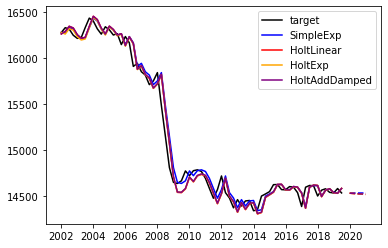

In [26]:
plt.figure()
plt.plot(df['DATE'], df['PER_CAP_REAL_SA_GDP_MA'], color='black', label='target')
plt.plot(df['DATE'], fit_simple.fittedvalues, color='blue', label='SimpleExp')
line1, = plt.plot(dates_pred, pred_simple, linestyle='dashed', color='blue')
plt.plot(df['DATE'], fit_holt_1.fittedvalues, color='red', label="HoltLinear")
line2, = plt.plot(dates_pred, pred_holt_1, linestyle='dashed', color='red')
plt.plot(df['DATE'], fit_holt_2.fittedvalues, color='orange', label="HoltExp")
line3, = plt.plot(dates_pred, pred_holt_2, linestyle='dashed', color='orange')
plt.plot(df['DATE'], fit_holt_3.fittedvalues, color='purple', label="HoltAddDamped")
line4, = plt.plot(dates_pred, pred_holt_3, linestyle='dashed', color='purple')
plt.legend(loc="upper right")
plt.show()

In the plot above, the dashed curves at the end are the predicted values for 5 periods.

The curves are quite close to each other, so it's hard to tell the difference visually, but we can calculate RMSE to compare their performance.

In [27]:
print("Simple Exponential Smoothing RMSE: ", ma.rmse(0, predicted=fit_simple.fittedvalues, target=df['PER_CAP_REAL_SA_GDP_MA']))
print("Holt's linear trend RMSE: ", ma.rmse(0, predicted=fit_holt_1.fittedvalues, target=df['PER_CAP_REAL_SA_GDP_MA']))
print("Holt's exponential trend RMSE: ", ma.rmse(0, predicted=fit_holt_2.fittedvalues, target=df['PER_CAP_REAL_SA_GDP_MA']))
print("Holt's additive damped trend RMSE: ", ma.rmse(0, predicted=fit_holt_3.fittedvalues, target=df['PER_CAP_REAL_SA_GDP_MA']))

Simple Exponential Smoothing RMSE:  108.53274169886627
Holt's linear trend RMSE:  107.27829402537911
Holt's exponential trend RMSE:  106.69761512462439
Holt's additive damped trend RMSE:  106.82197689012479


Based on the RMSE, Holt's exponential trend (Method 2-2) seems to have the best performance.

## Question 6

Compare the best MA forecast with the best Exponential Smoothing forecast.

In [28]:
print("2qt MA RMSE: ", ma.rmse(n_month=2, predicted=df['MA_2qt'], target=df['PER_CAP_REAL_SA_GDP_MA']))
print("Holt's exponential trend RMSE: ", ma.rmse(0, predicted=fit_holt_2.fittedvalues, target=df['PER_CAP_REAL_SA_GDP_MA']))

2qt MA RMSE:  135.91701499752799
Holt's exponential trend RMSE:  106.69761512462439


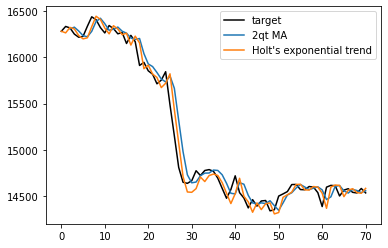

In [29]:
plt.figure()
plt.plot(df['PER_CAP_REAL_SA_GDP_MA'], color='black', label='target')
plt.plot(df['MA_2qt'][2:], label='2qt MA')
plt.plot(fit_holt_2.fittedvalues, label="Holt's exponential trend")
plt.legend(loc="upper right")
plt.show()

The best Exponential Smoothing forecast (Holt's method) has a lower RMSE than the best MA forecast (2-quarter MA).